# State Memory
As a graph executes, a snapshot of each state is stored in memory. A snapshot includes the agent state we have already defined, along with other useful information such as the thread and a unique identifier for each snapshot.

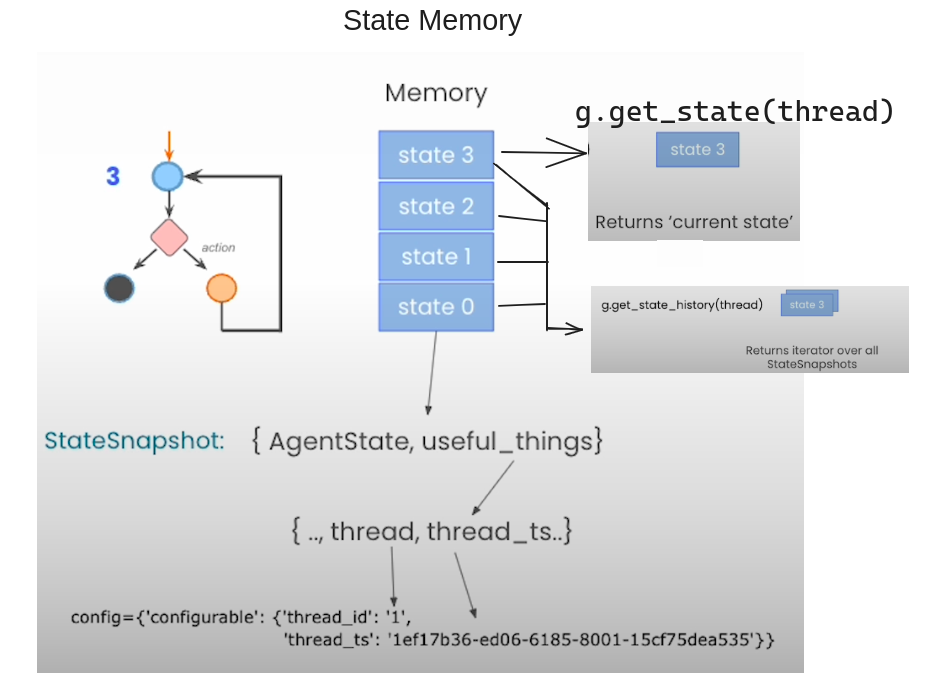

We can use invoke command to access any state and use that as current state using `thread_ts` the unique identifier
```python
g.invoke(None, {..., thread, thread_ts..})
g,strean(None, {..., thread, thread_ts..})
```

## Human in the Loop

In [1]:
import operator
from uuid import uuid4
from typing import TypedDict, Annotated

from langgraph.graph import StateGraph, END

from langchain_core.messages import (
    AnyMessage,
    SystemMessage,
    HumanMessage,
    ToolMessage
)
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_openai import ChatOpenAI

from dotenv import load_dotenv
from IPython.display import Image

# load dotenv
load_dotenv()

True

In [2]:
# initialize the tool
tool = TavilySearchResults(max_results=2)

# initialize the memory for saving state
memory = SqliteSaver.from_conn_string(":memory:")

In [3]:
def reduce_messages(left: list[AnyMessage], right: list[AnyMessage]) -> list[AnyMessage]:
    # assign id to messages that don't have them
    for message in right:
        if not message.id:
            message.id = str(uuid4())
    # merge the new messages with the existing messages
    merged  = left.copy()
    for message  in right:
        for i, existing in enumerate(merged):
            # replace any existing messages with same id
            if existing.id == message.id:
                merged[i] = message
                break
        else:
            # append any new messages to the end
            merged.append(message)
    return merged

In [4]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], reduce_messages]

### Manual Human Approval
We have added the `interrupt_before` parameter to the `graph.compile` method, which introduces an interrupt before calling the action node. This ensures that actions requiring manual approval are performed correctly.

LangGraph also supports interruptions when calling specific tools only. For more details, refer to the [documentation](https://langchain-ai.github.io/langgraph/reference/prebuilt/).

In [5]:
class Agent:
    def __init__(self, model, tools, system="", checkpointer=None):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges("llm", self.exists_action,
                                        {True: "action", False: END})
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile(checkpointer=checkpointer,
                                    interrupt_before=["action"])
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def call_openai(self, state: AgentState):
        messages = state["messages"]
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {"messages": [message]}

    def exists_action(self, state: AgentState):
        print(state)
        result = state["messages"][-1]
        return len(result.tool_calls) > 0

    def take_action(self, state: AgentState):
        tool_calls = state["messages"][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            result = self.tools[t["name"]].invoke(t["args"])
            results.append(ToolMessage(tool_call_id=t["id"],
                                        name=t["name"],
                                        content=str(result)))
        print("Back to the model!")
        return {"messages": results}

In [6]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""
model = ChatOpenAI(model="gpt-3.5-turbo")
abot = Agent(model, [tool], system=prompt, checkpointer=memory)

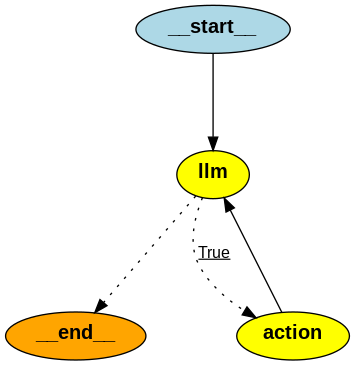

In [7]:
Image(abot.graph.get_graph().draw_png())

In [8]:
messages = [HumanMessage(content="Whats the weather inn SF?")]
thread = {"configurable": {"thread_id": "1"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

{'messages': [HumanMessage(content='Whats the weather inn SF?', id='312a5c46-6ba8-42b8-8d29-cb54c5e0868e'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_KcsgrC7vpMMZw1eAudde4izy', 'function': {'arguments': '{"query":"weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5b94ef1e-3bed-421a-8d5b-44f5198dc4ba-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_KcsgrC7vpMMZw1eAudde4izy'}])]}
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_KcsgrC7vpMMZw1eAudde4izy', 'function': {'arguments': '{"query":"weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_u

In [9]:
abot.graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather inn SF?', id='312a5c46-6ba8-42b8-8d29-cb54c5e0868e'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_KcsgrC7vpMMZw1eAudde4izy', 'function': {'arguments': '{"query":"weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5b94ef1e-3bed-421a-8d5b-44f5198dc4ba-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_KcsgrC7vpMMZw1eAudde4izy'}])]}, next=('action',), config={'configurable': {'thread_id': '1', 'thread_ts': '1ef39ce6-1c4b-65af-8001-4c908af1727a'}}, metadata={'source': 'loop', 'step': 1, 'writes': {'llm': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [

In [10]:
abot.graph.get_state(thread).next

('action',)

### Continue after interrupt
Here, the graph execute the tools and then calls the LLM after that. Since there is no any interrupt defined when going from actions to LLM.

In [11]:
for event in abot.graph.stream(None, thread):
    for v in event.values():
        print(v)

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_KcsgrC7vpMMZw1eAudde4izy'}
Back to the model!
{'messages': [ToolMessage(content='[{\'url\': \'https://weatherspark.com/h/y/557/2024/Historical-Weather-during-2024-in-San-Francisco-California-United-States\', \'content\': \'San Francisco Temperature History 2024\\nHourly Temperature in 2024 in San Francisco\\nCompare San Francisco to another city:\\nCloud Cover in 2024 in San Francisco\\nDaily Precipitation in 2024 in San Francisco\\nObserved Weather in 2024 in San Francisco\\nHours of Daylight and Twilight in 2024 in San Francisco\\nSunrise & Sunset with Twilight and Daylight Saving Time in 2024 in San Francisco\\nSolar Elevation and Azimuth in 2024 in San Francisco\\nMoon Rise, Set & Phases in 2024 in San Francisco\\nHumidity Comfort Levels in 2024 in San Francisco\\nWind Speed in 2024 in San Francisco\\nHourly Wind Speed in 2024 in San Francisco\\nHourly Wind Direction in 2024 i

In [12]:
abot.graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather inn SF?', id='312a5c46-6ba8-42b8-8d29-cb54c5e0868e'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_KcsgrC7vpMMZw1eAudde4izy', 'function': {'arguments': '{"query":"weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5b94ef1e-3bed-421a-8d5b-44f5198dc4ba-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_KcsgrC7vpMMZw1eAudde4izy'}]), ToolMessage(content='[{\'url\': \'https://weatherspark.com/h/y/557/2024/Historical-Weather-during-2024-in-San-Francisco-California-United-States\', \'content\': \'San Francisco Temperature History 2024\\nHourly Temperature in 2024 in San Francis

In [13]:
# the execution has ended. So it returns empty for next state
abot.graph.get_state(thread).next

()

### New Message thread

In [14]:
messages = [HumanMessage("Whats the weather in LA?")]

thread = {"configurable": {"thread_id": "2"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

while abot.graph.get_state(thread).next:
    print("\n", abot.graph.get_state(thread), "\n")
    _input = input("proceed?")
    if _input != "y":
        print("aborting")
        break
    for event in abot.graph.stream(None, thread):
        for v in event.values():
            print(v)

{'messages': [HumanMessage(content='Whats the weather in LA?', id='83fa84f3-55ec-4709-bfe8-4b0a052174e4'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_kLqyqM3LP0L06r2w8uNBgcXl', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-0974b6ce-9d9d-44d7-9428-238fbdbbf42f-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_kLqyqM3LP0L06r2w8uNBgcXl'}])]}
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_kLqyqM3LP0L06r2w8uNBgcXl', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': 

proceed? n


aborting


### Modify State

Run until the interrupt and then modify the state.

In [15]:
messages = [HumanMessage("Whats the weather in LA?")]

thread = {"configurable": {"thread_id": "3"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

{'messages': [HumanMessage(content='Whats the weather in LA?', id='a74ac744-a203-4931-8e5a-5c765d8a4cc4'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_jVARhVNJogQ5OXv2Je22PU7p', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-8f77d057-57dd-46e4-8ad6-d446583cd0ae-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_jVARhVNJogQ5OXv2Je22PU7p'}])]}
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_jVARhVNJogQ5OXv2Je22PU7p', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': 

In [16]:
abot.graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', id='a74ac744-a203-4931-8e5a-5c765d8a4cc4'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_jVARhVNJogQ5OXv2Je22PU7p', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-8f77d057-57dd-46e4-8ad6-d446583cd0ae-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_jVARhVNJogQ5OXv2Je22PU7p'}])]}, next=('action',), config={'configurable': {'thread_id': '3', 'thread_ts': '1ef39ce6-dc94-64ee-8001-79249af88e36'}}, metadata={'source': 'loop', 'step': 1, 'writes': {'llm': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id'

In [17]:
current_values = abot.graph.get_state(thread)

In [18]:
current_values.values["messages"][-1]

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_jVARhVNJogQ5OXv2Je22PU7p', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-8f77d057-57dd-46e4-8ad6-d446583cd0ae-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_jVARhVNJogQ5OXv2Je22PU7p'}])

In [19]:
current_values.values["messages"][-1].tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'weather in Los Angeles'},
  'id': 'call_jVARhVNJogQ5OXv2Je22PU7p'}]

In [20]:
_id = current_values.values["messages"][-1].tool_calls[0]["id"]
current_values.values["messages"][-1].tool_calls = [
    {"name": "tavily_search_results_json",
     "args": {"query": "current weather in Louisiana"},
     "id": _id}
]

In [21]:
# update the state by replacing what to call in tool
# instead of current weather in LA, call current weather in Louisiana
abot.graph.update_state(thread, current_values.values)

{'messages': [HumanMessage(content='Whats the weather in LA?', id='a74ac744-a203-4931-8e5a-5c765d8a4cc4'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_jVARhVNJogQ5OXv2Je22PU7p', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-8f77d057-57dd-46e4-8ad6-d446583cd0ae-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Louisiana'}, 'id': 'call_jVARhVNJogQ5OXv2Je22PU7p'}])]}


{'configurable': {'thread_id': '3',
  'thread_ts': '1ef39ce6-dd18-606c-8002-c883527191f8'}}

In [22]:
abot.graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', id='a74ac744-a203-4931-8e5a-5c765d8a4cc4'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_jVARhVNJogQ5OXv2Je22PU7p', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-8f77d057-57dd-46e4-8ad6-d446583cd0ae-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Louisiana'}, 'id': 'call_jVARhVNJogQ5OXv2Je22PU7p'}])]}, next=('action',), config={'configurable': {'thread_id': '3', 'thread_ts': '1ef39ce6-dd18-606c-8002-c883527191f8'}}, metadata={'source': 'update', 'step': 2, 'writes': {'llm': {'messages': [HumanMessage(content='Whats the weather in LA?', id='

In [23]:
for event in abot.graph.stream(None, thread):
    for v in event.values():
        print(v)

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Louisiana'}, 'id': 'call_jVARhVNJogQ5OXv2Je22PU7p'}
Back to the model!
{'messages': [ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'Louisiana\', \'region\': \'Missouri\', \'country\': \'USA United States of America\', \'lat\': 39.44, \'lon\': -91.06, \'tz_id\': \'America/Chicago\', \'localtime_epoch\': 1720074363, \'localtime\': \'2024-07-04 1:26\'}, \'current\': {\'last_updated_epoch\': 1720073700, \'last_updated\': \'2024-07-04 01:15\', \'temp_c\': 24.3, \'temp_f\': 75.7, \'is_day\': 0, \'condition\': {\'text\': \'Partly cloudy\', \'icon\': \'//cdn.weatherapi.com/weather/64x64/night/116.png\', \'code\': 1003}, \'wind_mph\': 2.2, \'wind_kph\': 3.6, \'wind_degree\': 10, \'wind_dir\': \'N\', \'pressure_mb\': 1016.0, \'pressure_in\': 29.99, \'precip_mm\': 0.39, \'precip_in\': 0.02, \'humidity\': 98, \'cloud\': 50, \'feelslike_c\': 26.4, \'feels

### Time Travel
We can use the state from histroy to initialize it as current state and proceed from that point in the graph. 

In [24]:
states = []
for state in abot.graph.get_state_history(thread):
    print(state)
    print('----')
    states.append(state)

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', id='a74ac744-a203-4931-8e5a-5c765d8a4cc4'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_jVARhVNJogQ5OXv2Je22PU7p', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-8f77d057-57dd-46e4-8ad6-d446583cd0ae-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Louisiana'}, 'id': 'call_jVARhVNJogQ5OXv2Je22PU7p'}]), ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'Louisiana\', \'region\': \'Missouri\', \'country\': \'USA United States of America\', \'lat\': 39.44, \'lon\': -91.06, \'tz_id\': \'Ameri

In [29]:
# fetch the fist dtate
to_replay = states[-3]
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', id='a74ac744-a203-4931-8e5a-5c765d8a4cc4'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_jVARhVNJogQ5OXv2Je22PU7p', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-8f77d057-57dd-46e4-8ad6-d446583cd0ae-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_jVARhVNJogQ5OXv2Je22PU7p'}])]}, next=('action',), config={'configurable': {'thread_id': '3', 'thread_ts': '1ef39ce6-dc94-64ee-8001-79249af88e36'}}, metadata={'source': 'loop', 'step': 1, 'writes': {'llm': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id'

In [30]:
for event in abot.graph.stream(None, to_replay.config):
    for k, v in event.items():
        print(v)

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_jVARhVNJogQ5OXv2Je22PU7p'}
Back to the model!
{'messages': [ToolMessage(content='[{\'url\': \'https://www.wunderground.com/hourly/us/ca/los-Ángeles/90022/date/2024-07-04\', \'content\': \'Los Angeles Weather Forecasts. Weather Underground provides local & long-range weather forecasts, weatherreports, maps & tropical weather conditions for the Los Angeles area. ... Thursday 07/04 ...\'}, {\'url\': \'https://www.timeanddate.com/weather/usa/los-angeles/historic?month=4&year=2024\', \'content\': \'Weather reports from April 2024 in Los Angeles, California, USA with highs and lows. Sign in. News. News Home; Astronomy News; ... April 2024 Weather in Los Angeles — Graph °F. See Hour-by-hour Forecast for upcoming weather. ... 30.07 "Hg: 10 mi:\'}]', name='tavily_search_results_json', tool_call_id='call_jVARhVNJogQ5OXv2Je22PU7p')]}
{'messages': [HumanMessage(content='Whats the weather in LA?

### Going in previous State and Edit

In [31]:
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', id='a74ac744-a203-4931-8e5a-5c765d8a4cc4'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_jVARhVNJogQ5OXv2Je22PU7p', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-8f77d057-57dd-46e4-8ad6-d446583cd0ae-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_jVARhVNJogQ5OXv2Je22PU7p'}])]}, next=('action',), config={'configurable': {'thread_id': '3', 'thread_ts': '1ef39ce6-dc94-64ee-8001-79249af88e36'}}, metadata={'source': 'loop', 'step': 1, 'writes': {'llm': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id'

In [32]:
_id = to_replay.values["messages"][-1].tool_calls[0]['id']
to_replay.values['messages'][-1].tool_calls = [
    {'name': 'tavily_search_results_json',
      'args': {'query': 'current weather in LA, accuweather'},
      'id': _id}
]

In [33]:
branch_state = abot.graph.update_state(to_replay.config, to_replay.values)

{'messages': [HumanMessage(content='Whats the weather in LA?', id='a74ac744-a203-4931-8e5a-5c765d8a4cc4'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_jVARhVNJogQ5OXv2Je22PU7p', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-8f77d057-57dd-46e4-8ad6-d446583cd0ae-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in LA, accuweather'}, 'id': 'call_jVARhVNJogQ5OXv2Je22PU7p'}])]}


In [34]:
for event in abot.graph.stream(None, branch_state):
    for k, v in event.items():
        if k != "__end__":
            print(v)

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in LA, accuweather'}, 'id': 'call_jVARhVNJogQ5OXv2Je22PU7p'}
Back to the model!
{'messages': [ToolMessage(content='[{\'url\': \'https://www.wunderground.com/hourly/us/ca/los-Ángeles/90022/date/2024-07-04\', \'content\': \'Los Angeles Weather Forecasts. Weather Underground provides local & long-range weather forecasts, weatherreports, maps & tropical weather conditions for the Los Angeles area. ... Current Weather ...\'}, {\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'Los Angeles\', \'region\': \'California\', \'country\': \'United States of America\', \'lat\': 34.05, \'lon\': -118.24, \'tz_id\': \'America/Los_Angeles\', \'localtime_epoch\': 1720074387, \'localtime\': \'2024-07-03 23:26\'}, \'current\': {\'last_updated_epoch\': 1720073700, \'last_updated\': \'2024-07-03 23:15\', \'temp_c\': 18.3, \'temp_f\': 64.9, \'is_day\': 0, \'condition\': {\'text\': \'Overcast\',

### Add message to a state at a gievn time

In [35]:
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', id='a74ac744-a203-4931-8e5a-5c765d8a4cc4'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_jVARhVNJogQ5OXv2Je22PU7p', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-8f77d057-57dd-46e4-8ad6-d446583cd0ae-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in LA, accuweather'}, 'id': 'call_jVARhVNJogQ5OXv2Je22PU7p'}])]}, next=('action',), config={'configurable': {'thread_id': '3', 'thread_ts': '1ef39ce6-dc94-64ee-8001-79249af88e36'}}, metadata={'source': 'loop', 'step': 1, 'writes': {'llm': {'messages': [AIMessage(content='', additional_kwargs={'tool_ca

#### Updating the message manually rather than calling tools

In [36]:
_id = to_replay.values['messages'][-1].tool_calls[0]['id']

state_update = {
    "messages": [
        ToolMessage(
            tool_call_id=_id,
            name="tavily_search_results_json",
            content="54 degree celcius",
        )
    ]
}

In [37]:
branch_and_add = abot.graph.update_state(
    to_replay.config, 
    state_update, 
    as_node="action")

In [38]:
for event in abot.graph.stream(None, branch_and_add):
    for k, v in event.items():
        print(v)

{'messages': [HumanMessage(content='Whats the weather in LA?', id='a74ac744-a203-4931-8e5a-5c765d8a4cc4'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_jVARhVNJogQ5OXv2Je22PU7p', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-8f77d057-57dd-46e4-8ad6-d446583cd0ae-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_jVARhVNJogQ5OXv2Je22PU7p'}]), ToolMessage(content='54 degree celcius', name='tavily_search_results_json', id='38fbce75-67fa-45d4-bb97-51bf270ad570', tool_call_id='call_jVARhVNJogQ5OXv2Je22PU7p'), AIMessage(content='The current weather in Los Angeles is 54 degrees Celsius.', response_metadata={'token_